In [2]:
from typing import List
import string
import numpy as np
import h5py
import urllib3
import PIL
from io import BytesIO, StringIO
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
import os
import pickle
import random
import time
import pandas as pd
import tensorflow as tf
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend as K
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
from pathlib import Path
import re
from IPython import display

model = VGG16(weights='imagenet')

553476096/553467096 [==============================] - 6s 0us/step


# Load COCO dataset from web

In [3]:
# Import the training and test data from HDF5 files.
with h5py.File('/content/drive/MyDrive/Neural Project/required/eee443_project_dataset_train.h5','r') as trainh5:
  traincaps = list(trainh5['train_cap'])
  trainimgind = list(trainh5['train_imid'])
  trainURLs = list(trainh5['train_url'])

with h5py.File('/content/drive/MyDrive/Neural Project/required/eee443_project_dataset_test.h5','r') as testh5:
  testcaps = list(testh5['test_caps'])
  testimgind = list(testh5['test_imid'])
  testURLs = list(testh5['test_url'])

In [4]:
# The dictionary is imported via MATLAB and converted to numpy.ndarray 
word_ind = scipy.io.loadmat('/content/drive/MyDrive/Neural Project/required/word_inds.mat')
word_indexes = (word_ind['word_inds'])

with open('/content/drive/MyDrive/Neural Project/required/words.txt', 'r') as words:
    word_str = words.readlines()

word_names = []
for x in word_str:
    word_names.append(x.replace("\n", ""))
#word_names.append(" ")
word_names = np.reshape(word_names,(1004,1))

# From list tot np.array
traincaption = np.array(traincaps)
trainimid = np.array(trainimgind)

testcaption = np.array(testcaps)
testimid = np.array(testimgind)

# GloVe word embedding
glove = open("/content/drive/MyDrive/Neural Project/required/glove.6B.50d.txt",encoding='utf8')

embedding_index = {}
for line in glove :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding

In [5]:
word_names

array([['shop'],
       ['all'],
       ['seated'],
       ...,
       ['fresh'],
       ['baked'],
       ['having']], dtype='<U13')

In [6]:
urllib3.disable_warnings()

def get_image(index):
  """
  Download image from internet by using URL
  """
  y = 0
  url = trainURLs[index].decode('UTF-8')
  http = urllib3.PoolManager()
  r = http.request('GET', url)
  while True:
    try:
         image = Image.open(BytesIO(r.data))
         if len(np.shape(image)) != 3:
          y = 1
          return y
         else:
          return image
         break
    except PIL.UnidentifiedImageError:
         y = 1
         return y
         break

def get_sentence(index):
  """
  Get sentences for corresponding images
  """
  endsentence = np.where(traincaption[index,:]==2)
  endsentence = endsentence[0]
  endsentence = endsentence[0]
  x = traincaption[index,1:endsentence]
  sentence = []
  for i in x:
    k = np.where(word_indexes == i)
    m = word_names[k]
    m = m[0]
    if m == 'x_UNK_':
      x = np.delete(x,3)
      pass
    else:
      sentence.append(m)
  return sentence,x

def sentence_encoding(sentence):
  """
  Encode sentecnces using GloVe
  """
  sentence_array = []
  for word in sentence:
    word_array = embedding_index["word"]
    sentence_array = np.concatenate((sentence_array, word_array), axis=None)
  if len(sentence_array)<15*50:
    num_missing = 15*50-len(sentence_array)
    zeros = np.zeros((num_missing,),dtype=int)
    sentence_array = np.concatenate((sentence_array, zeros), axis=None)  
  return sentence_array

def get_encoded_image(index):
  """
  Use VGG-16 pretrained model for image encoding
  """
  img = get_image(index)
  img = img.resize((224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  get_feature = K.function([model.layers[0].input],
                                  [model.layers[-2].output])
  layer_output = get_feature([x])[0][0]
  return np.array(layer_output)

def save_train_images(index):
  """
  Save images to the drive and retun saved images path and corresponding sentences
  """
  sentences = np.where(trainimid == index)[0]
  img = get_image(index-1)
  if img == 1:
    sentences = "pass"
    path = "pass"
    pass
  else:
    img = img.resize((64,64), Image.ANTIALIAS)
    try:
      img.save('/content/drive/MyDrive/Neural Project/real_train/'+ str(index) +'.png')
      path = "/content/drive/MyDrive/Neural Project/real_train/"+ str(index) +'.png'
    except OSError:
      img.convert('RGB').save('/content/drive/MyDrive/Neural Project/real_train/'+ str(index) +'.png', "PNG", optimize=True)
  return sentences,path

def word_to_id (sentences):
  """
  Turns words in sentences into corresponding IDs in the word dicitonary 
  """
  sentences_word_id = []
  for sentence in sentences:
    sent,word_id = get_sentence(sentence)
    while len(word_id)<15:
      word_id = np.append(word_id,1004)
    sentences_word_id.append(word_id)
  return np.array(sentences_word_id)


In [ ]:
# Run this cell once: Image gathering from dataset
df = pd.DataFrame(columns = ['ID','Captions','ImagePath'])
sents = []
imgids = []
paths = []
for i in range(1,8000):
  sentences,path = save_train_images(i)
  if sentences == "pass":
    pass
  else:
    word_id = word_to_id (sentences)
    sents.append(word_id)
    imgids.append(i)
    paths.append(path)
    if i%100 == 0 :
      print(str(i)+ "th image is saved")
#create dataframe that stores converted sentences and corresponding image's path
df = pd.DataFrame({'ID': np.array(imgids), 'Captions': sents, 'ImagePath': paths}).set_index('ID')
#save df as pickle file for futher use
df.to_pickle("/content/drive/MyDrive/Neural Project/data_frame.pkl")

# Create Dataset by TensorFlow API

In [8]:
#read df from pickle
df = pd.read_pickle('/content/drive/MyDrive/Neural Project/data_frame.pkl')
df

Captions  \
ID                                                        
1     [[4, 341, 54, 592, 99, 506, 10, 287, 1004, 100...   
2     [[4, 12, 372, 4, 62, 135, 8, 3, 1004, 1004, 10...   
3     [[4, 168, 48, 26, 4, 12, 11, 17, 8, 1004, 1004...   
5     [[4, 155, 10, 23, 20, 576, 8, 7, 62, 1004, 100...   
7     [[7, 683, 91, 5, 7, 137, 11, 38, 4, 99, 24, 10...   
...                                                 ...   
4132  [[16, 3, 50, 185, 18, 4, 498, 62, 1004, 1004, ...   
4133  [[36, 138, 101, 3, 3, 3, 5, 4, 24, 1004, 1004,...   
4134  [[65, 11, 4, 26, 11, 46, 5, 4, 3, 8, 7, 25, 10...   
4135  [[141, 23, 11, 38, 4, 226, 38, 4, 705, 3, 1004...   
4136  [[4, 226, 26, 455, 321, 4, 3, 480, 1004, 1004,...   

                                       ImagePath  
ID                                                
1        /content/drive/MyDrive/real_train/1.png  
2        /content/drive/MyDrive/real_train/2.png  
3        /content/drive/MyDrive/real_train/3.png  
5        /content/drive/MyDrive/real_train/5.png  
7        /content/drive/MyDrive/real_train/7.png  
...                                          ...  
4132  /content/drive/MyDrive/real_train/4132.png  
4133  /content/drive/MyDrive/real_train/4133.png  
4134  /content/drive/MyDrive/real_train/4134.png  
4135  /content/drive/MyDrive/real_train/4135.png  
4136  /content/drive/MyDrive/real_train/4136.png  

[3484 rows x 2 columns]

In [34]:
def image_to_tensor(caption, image_path):
  """
  Load the image and caption according to image path into tensor using its own functions
  """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image.set_shape([None, None, 3])
  image = tf.image.resize(image, size=[64, 64])
  image.set_shape([64, 64, 3])
  caption = tf.cast(caption, tf.int32)
  return image, caption

def train_dataset_generator(df, batch_size, image_to_tensor):
  """
  Using the image_to_tensor method crate appropiate dataset as input to network
  """
  captions = df['Captions'].values
  image_path = df['ImagePath'].values
  caption = []
  for i in range(len(captions)):
      caption.append(random.choice(captions[i]))
  caption = np.asarray(caption)
  caption = caption.astype(np.int)
  train_dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
  train_dataset = train_dataset.map(image_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_dataset = train_dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
  train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return train_dataset

In [52]:
#Since batch size chosen by us is 64 function called accordingly
train_dataset = train_dataset_generator(df, 64, image_to_tensor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Conditional GAN Model

## Text Encoder 

In [10]:
class TextEncoder(tf.keras.Model):
  """
  Encode text (a caption) into hidden representation
  input: text, which is a list of ids
  output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
  """
  def __init__(self, hparas):
      super(TextEncoder, self).__init__()
      self.hparas = hparas
      self.batch_size = self.hparas['BATCH_SIZE']
      self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
      self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
  
  def call(self, text, hidden):
      text = self.embedding(text)
      output, state = self.gru(text, initial_state = hidden)
      return output[:, -1, :], state
  
  def initialize_hidden_state(self):
      return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

## Generator Class

In [11]:
class Generator(tf.keras.Model):
  """
  Generate fake image based on given text(hidden representation) and noise z
  input: text and noise
  output: fake image with size 64*64*3
  """
  def __init__(self, hparas):
      super(Generator, self).__init__()
      self.hparas = hparas
      self.flatten = tf.keras.layers.Flatten()
      self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
      self.d2 = tf.keras.layers.Dense(64*64*3)
      
  def call(self, text, noise_z):
      text = self.flatten(text)
      text = self.d1(text)
      text = tf.nn.leaky_relu(text)
      concatinated_text = tf.concat([noise_z, text], axis=1)
      concatinated_text = self.d2(concatinated_text)
      logits = tf.reshape(concatinated_text, [-1, 64, 64, 3])
      output = tf.nn.tanh(logits)
      
      return logits, output

## Discriminator

In [12]:
class Discriminator(tf.keras.Model):
  """
  Differentiate the real and fake image
  input: image and corresponding text
  output: labels, the real image should be 1, while the fake should be 0
  """
  def __init__(self, hparas):
      super(Discriminator, self).__init__()
      self.hparas = hparas
      self.flatten = tf.keras.layers.Flatten()
      self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
      self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
      self.d = tf.keras.layers.Dense(1)
  
  def call(self, img, text):
      text = self.flatten(text)
      text = self.d_text(text)
      text = tf.nn.leaky_relu(text)
      image = self.flatten(img)
      image = self.d_img(image)
      image = tf.nn.leaky_relu(image)      
      img_text = tf.concat([text, image], axis=1)
      logits = self.d(img_text)
      output = tf.nn.sigmoid(logits)
      
      return logits, output

In [13]:
hparas = {
          'MAX_SEQ_LENGTH': 15,                     
          'EMBED_DIM': 256,                         
          'VOCAB_SIZE': 1004,                       
          'RNN_HIDDEN_SIZE': 128,                   
          'Z_DIM': 512,                             
          'DENSE_DIM': 128,                         
          'IMAGE_SIZE': [64, 64, 3],                
          'BATCH_SIZE': 64,
          'LR': 1e-4,
          'LR_DECAY': 0.5,
          'BETA_1': 0.5,
          'N_EPOCH': 600,
          'N_SAMPLE': len(df),                      
          'PRINT_FREQ': 100,                           
          }
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

## Optimizer and Loss Function

In [14]:
def loss(real_logits, fake_logits):
  """
  Function returns discriminator and generator loss using cross entropy loss
  """
  cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  loss_real_image = cross_entropy_loss(tf.ones_like(real_logits), real_logits)
  loss_fake_image = cross_entropy_loss(tf.zeros_like(fake_logits), fake_logits)
  discriminator_loss = loss_real_image + loss_fake_image
  generator_loss = cross_entropy_loss(tf.ones_like(fake_logits), fake_logits)

  return discriminator_loss,generator_loss

In [15]:
# Using adam for optimizer
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

# Train and Test Steps

In [38]:
@tf.function
def train_step(real_image, caption, hidden):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embed, hidden = text_encoder(caption, hidden)
        _, fake_image = generator(text_embed, noise)
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)
        
        d_loss,g_loss = loss(real_logits, fake_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss

@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise)
    return fake_image

In [39]:
checkpoint_prefix = "/content/drive/MyDrive/Neural Project/demo/checkpoints/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
ni = 8
sample_size = 64
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(64, 512)).astype(np.float32)
sample_list = [[4, 341, 54, 592, 99, 506, 10, 287, 1005, 1005, 1005, 1005, 1005, 1005, 1005],
               [4, 12, 372, 4, 62, 135, 8, 3, 1005, 1005, 1005, 1005, 1005, 1005, 1005],
               [4, 168, 48, 26, 4, 12, 11, 17, 8, 1005, 1005, 1005, 1005, 1005, 1005],
               [4, 155, 10, 23, 20, 576, 8, 7, 62, 1005, 1005, 1005, 1005, 1005, 1005],
               [7, 683, 91, 5, 7, 137, 11, 38, 4, 99, 24, 1005, 1005, 1005, 1005],
               [94, 19, 20, 5, 7, 195, 124, 4, 64, 3, 50, 1005, 1005, 1005, 1005],
               [37, 22, 62, 9, 4, 226, 10, 764, 66, 8, 31, 1005, 1005, 1005, 1005],
               [16, 19, 8, 61, 125, 107, 72, 18, 15, 3, 1005, 1005, 1005, 1005, 1005]]

def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

def create_sample(sample_list):
  samples = []
  for sentence in sample_list:
    sentences = []
    for word in sentence:
      sentences.append(str(word))
    for i in range(8):
      samples.append(sentences)
  return samples

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [41]:
def train(dataset, epochs):
    samples = create_sample(sample_list) 
    sample = sample_generator(samples, sample_size)
    hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        for image, caption in dataset:
            g_loss, d_loss = train_step(image, caption, hidden)
            g_total_loss += g_loss
            d_total_loss += d_loss
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
        print("Epoch {}, generative loss: {:.4f}, discriminator loss: {:.4f}".format(epoch+1,g_total_loss/steps_per_epoch,d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        # save the model at each 50 epoch 
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # show generated images from sample sentence
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
          for caption in sample:
            fake_image = test_step(caption, sample_seed, hidden)
          im = merge(fake_image,[8,8])
          plt.figure(figsize = (10,10))
          plt.imshow(im)
          plt.show()
          save_images(fake_image, [8, 8], '/content/drive/MyDrive/Neural Project/demo/train_{:02d}.jpg'.format(epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


Epoch 1, generative loss: 182.3629, discriminator loss: 20.6239
Time for epoch 1 is 3.6133 sec
Epoch 2, generative loss: 161.6679, discriminator loss: 21.9109
Time for epoch 2 is 3.3526 sec
Epoch 3, generative loss: 166.6181, discriminator loss: 27.2159
Time for epoch 3 is 3.2207 sec
Epoch 4, generative loss: 146.5066, discriminator loss: 32.2548
Time for epoch 4 is 3.2226 sec
Epoch 5, generative loss: 136.9267, discriminator loss: 35.6639
Time for epoch 5 is 3.2885 sec
Epoch 6, generative loss: 135.1602, discriminator loss: 35.6728
Time for epoch 6 is 3.2700 sec
Epoch 7, generative loss: 134.0261, discriminator loss: 41.9064
Time for epoch 7 is 3.2893 sec
Epoch 8, generative loss: 127.8801, discriminator loss: 45.3129
Time for epoch 8 is 3.2614 sec
Epoch 9, generative loss: 140.1673, discriminator loss: 39.5675
Time for epoch 9 is 3.2533 sec
Epoch 10, generative loss: 132.1665, discriminator loss: 40.8996
Time for epoch 10 is 3.2408 sec
Epoch 11, generative loss: 120.6011, discriminat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


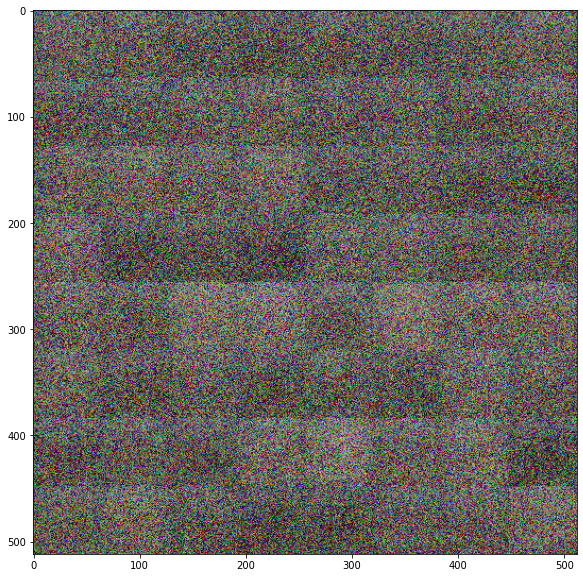

Epoch 101, generative loss: 76.8225, discriminator loss: 54.5368
Time for epoch 101 is 3.1815 sec
Epoch 102, generative loss: 70.2571, discriminator loss: 57.3134
Time for epoch 102 is 3.3004 sec
Epoch 103, generative loss: 77.0262, discriminator loss: 49.0096
Time for epoch 103 is 3.3518 sec
Epoch 104, generative loss: 80.4903, discriminator loss: 47.5140
Time for epoch 104 is 3.4311 sec
Epoch 105, generative loss: 81.9436, discriminator loss: 50.1086
Time for epoch 105 is 3.2375 sec
Epoch 106, generative loss: 74.1053, discriminator loss: 50.6023
Time for epoch 106 is 3.2160 sec
Epoch 107, generative loss: 65.6975, discriminator loss: 52.7750
Time for epoch 107 is 5.1125 sec
Epoch 108, generative loss: 62.8459, discriminator loss: 51.7231
Time for epoch 108 is 3.2666 sec
Epoch 109, generative loss: 72.9088, discriminator loss: 46.6109
Time for epoch 109 is 3.2062 sec
Epoch 110, generative loss: 62.6413, discriminator loss: 56.2462
Time for epoch 110 is 3.2293 sec
Epoch 111, generativ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


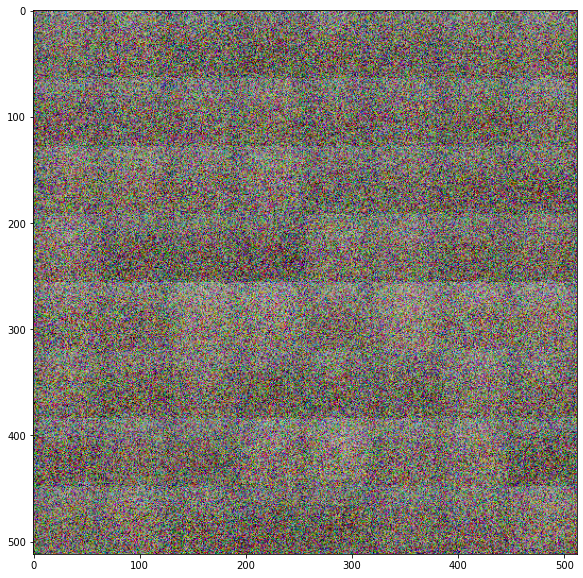

Epoch 201, generative loss: 52.5316, discriminator loss: 76.9177
Time for epoch 201 is 3.1711 sec
Epoch 202, generative loss: 59.9806, discriminator loss: 68.7595
Time for epoch 202 is 3.2633 sec
Epoch 203, generative loss: 62.2026, discriminator loss: 71.6908
Time for epoch 203 is 3.4603 sec
Epoch 204, generative loss: 60.0092, discriminator loss: 73.4931
Time for epoch 204 is 3.2352 sec
Epoch 205, generative loss: 67.1823, discriminator loss: 69.3988
Time for epoch 205 is 3.1818 sec
Epoch 206, generative loss: 67.9931, discriminator loss: 75.8737
Time for epoch 206 is 3.2194 sec
Epoch 207, generative loss: 67.3503, discriminator loss: 74.8594
Time for epoch 207 is 3.1744 sec
Epoch 208, generative loss: 73.0217, discriminator loss: 67.7347
Time for epoch 208 is 3.1723 sec
Epoch 209, generative loss: 105.4501, discriminator loss: 52.7871
Time for epoch 209 is 3.2073 sec
Epoch 210, generative loss: 78.3445, discriminator loss: 69.2592
Time for epoch 210 is 3.1845 sec
Epoch 211, generati

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


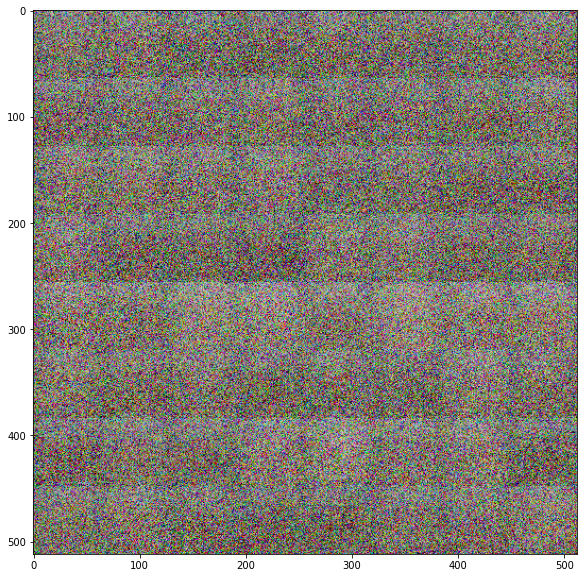

Epoch 301, generative loss: 54.8548, discriminator loss: 73.4334
Time for epoch 301 is 3.2133 sec
Epoch 302, generative loss: 75.3488, discriminator loss: 61.5180
Time for epoch 302 is 3.0729 sec
Epoch 303, generative loss: 73.8038, discriminator loss: 67.6003
Time for epoch 303 is 5.1110 sec
Epoch 304, generative loss: 68.2467, discriminator loss: 76.6662
Time for epoch 304 is 3.1804 sec
Epoch 305, generative loss: 59.5663, discriminator loss: 80.0652
Time for epoch 305 is 3.1952 sec
Epoch 306, generative loss: 70.6744, discriminator loss: 64.5528
Time for epoch 306 is 3.0855 sec
Epoch 307, generative loss: 92.1032, discriminator loss: 53.3514
Time for epoch 307 is 3.1988 sec
Epoch 308, generative loss: 84.6805, discriminator loss: 68.3658
Time for epoch 308 is 5.1205 sec
Epoch 309, generative loss: 77.2861, discriminator loss: 76.7665
Time for epoch 309 is 3.1118 sec
Epoch 310, generative loss: 80.2415, discriminator loss: 69.9868
Time for epoch 310 is 3.2048 sec
Epoch 311, generativ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


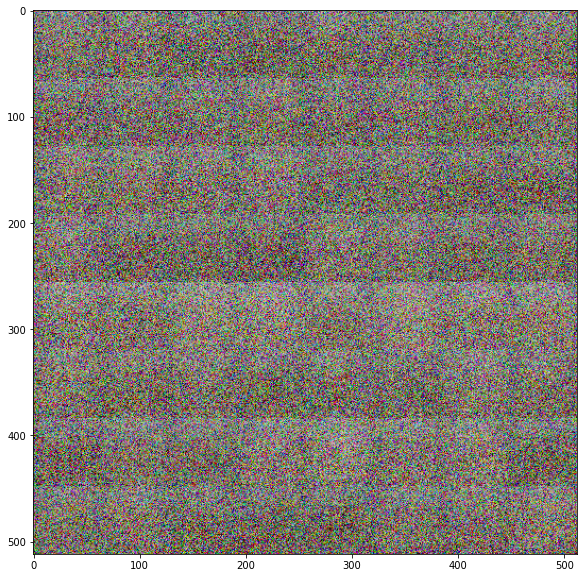

Epoch 401, generative loss: 91.7224, discriminator loss: 51.5907
Time for epoch 401 is 3.1050 sec
Epoch 402, generative loss: 75.2289, discriminator loss: 58.2475
Time for epoch 402 is 5.1124 sec
Epoch 403, generative loss: 56.9104, discriminator loss: 75.3446
Time for epoch 403 is 3.4957 sec
Epoch 404, generative loss: 60.7909, discriminator loss: 67.6089
Time for epoch 404 is 3.1729 sec
Epoch 405, generative loss: 66.6347, discriminator loss: 67.2534
Time for epoch 405 is 3.1074 sec
Epoch 406, generative loss: 71.2391, discriminator loss: 66.2964
Time for epoch 406 is 3.2379 sec
Epoch 407, generative loss: 87.8201, discriminator loss: 62.0045
Time for epoch 407 is 3.2296 sec
Epoch 408, generative loss: 64.7306, discriminator loss: 80.2447
Time for epoch 408 is 3.1504 sec
Epoch 409, generative loss: 72.0712, discriminator loss: 66.9790
Time for epoch 409 is 3.2068 sec
Epoch 410, generative loss: 80.3977, discriminator loss: 59.9134
Time for epoch 410 is 5.1174 sec
Epoch 411, generativ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


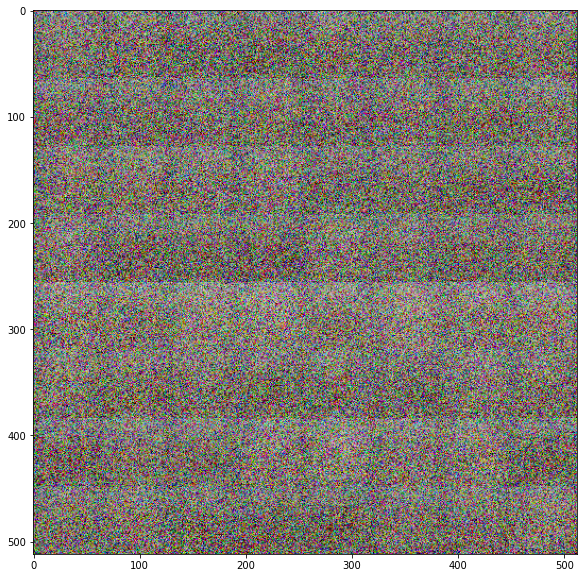

Epoch 501, generative loss: 69.3913, discriminator loss: 67.4165
Time for epoch 501 is 3.2342 sec
Epoch 502, generative loss: 74.1823, discriminator loss: 64.7787
Time for epoch 502 is 3.1951 sec
Epoch 503, generative loss: 121.7320, discriminator loss: 35.0311
Time for epoch 503 is 3.1214 sec
Epoch 504, generative loss: 103.9468, discriminator loss: 44.7990
Time for epoch 504 is 3.4548 sec
Epoch 505, generative loss: 99.1440, discriminator loss: 42.5977
Time for epoch 505 is 3.1412 sec
Epoch 506, generative loss: 97.9971, discriminator loss: 43.8265
Time for epoch 506 is 3.1883 sec
Epoch 507, generative loss: 76.9866, discriminator loss: 57.5430
Time for epoch 507 is 5.1130 sec
Epoch 508, generative loss: 73.4116, discriminator loss: 63.4106
Time for epoch 508 is 3.2327 sec
Epoch 509, generative loss: 70.8272, discriminator loss: 65.1348
Time for epoch 509 is 3.2533 sec
Epoch 510, generative loss: 86.3485, discriminator loss: 52.8671
Time for epoch 510 is 3.3788 sec
Epoch 511, generat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


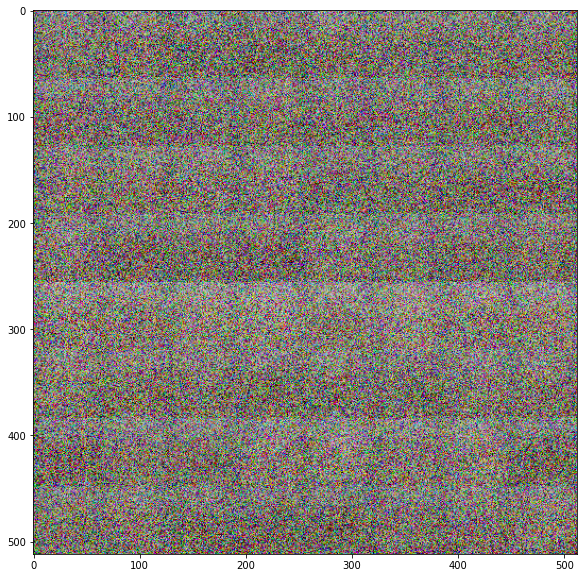

In [53]:
train(train_dataset, hparas['N_EPOCH'])